In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import copy
import numpy as np
import time
import syft
import matplotlib.pyplot as pp

import utils
from ipynb.fs.full.MNIST_IID_DataLoading import load_dataset, get_actual_images

In [37]:
class Arguments():
    def __init__(self, clients=5, epochs=2):
        self.images = 60000
        self.clients = clients
        self.rounds = 2
        self.epochs = epochs 
        self.local_batches = 1
        self.lr = 0.01
        self.c = 0.9
        self.drop_rate = 0.1
        self.torch_seed = 0
        self.log_interval = 100
        self.iid = "iid"
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images
        self.use_cuda = False
        self.save_model = False

args = Arguments()
use_cuda = args.use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [38]:
hook = syft.TorchHook(torch)
clients = []
for i in range(args.clients):
    clients.append({"hook": syft.VirtualWorker(hook, id=f"client{i+1}")})

In [39]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid)

In [40]:
for inx, client in enumerate(clients):
    trainset_ind_list = list(train_group[inx])
    client['trainset'] = get_actual_images(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = get_actual_images(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images

In [41]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

torch.manual_seed(args.torch_seed)
global_model = Net().to(device)

In [43]:
def ClientUpdate(args, device, client, losses_dict):
    client['model'].train()
    client['model'].send(client['hook'])
    
    for epoch in range(1, args.epochs + 1):
        for batch_idx, (data, target) in enumerate(client['trainset']):
            data = data.send(client['hook'])
            target = target.send(client['hook'])
            
            data, target = data.to(device), target.to(device)
            client['optim'].zero_grad()
            output = client['model'](data)
            loss = F.nll_loss(output, target)
            loss.backward()
            client['optim'].step()
            
            if batch_idx % args.log_interval == 0:
                loss = loss.get() 
                print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    client['hook'].id,
                    epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                    100. * batch_idx / len(client['trainset']), loss))
                if losses_dict.get(client["hook"].id, None):
                    losses_dict[client["hook"].id].append(loss)
                else:
                    losses_dict[client["hook"].id] = [loss]
                
    client['model'].get()

In [44]:
def test(args, model, device, test_loader, name):
    model.eval()   
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [45]:
for client in clients:
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    
losses_dict = {}
    
for fed_round in range(args.rounds):
    # randomized ration of available devices
    args.c = float(format(np.random.random(), '.1f'))
    
    # number of selected clients
    m = int(max(args.c * args.clients, 1))
    
    # Selected devices
    np.random.seed(fed_round)
    selected_client_inds = np.random.choice(range(len(clients)), m, replace = False)
    selected_clients = [clients[i] for i in selected_client_inds]
    
    # Active devices
    np.random.seed(fed_round)
    active_client_inds = np.random.choice(selected_client_inds, int((1 - args.drop_rate) * m), replace = False)
    active_clients = [clients[i] for i in active_client_inds]
    
    # Training
    for client in active_clients:
        ClientUpdate(args, device, client, losses_dict)
            
    # Federated Averaging (change active_clients to clients to average all clients)
    global_model = utils.average_models(global_model, active_clients)
        
    # Testing averaged model
    test(args, global_model, device, global_test_loader, 'Global')
    
    # Share global model with all clients
    for client in clients:
        client['model'].load_state_dict(global_model.state_dict())
        
    
if args.save_model:
    torch.save(global_model.state_dict(), "fedavg.pt")

    

Model client1 Train Epoch: 1 [0/12000 (0%)]	Loss: 2.266853
Model client1 Train Epoch: 1 [100/12000 (1%)]	Loss: 2.438442
Model client1 Train Epoch: 1 [200/12000 (2%)]	Loss: 0.678407
Model client1 Train Epoch: 1 [300/12000 (2%)]	Loss: 2.309254
Model client1 Train Epoch: 1 [400/12000 (3%)]	Loss: 0.895591
Model client1 Train Epoch: 1 [500/12000 (4%)]	Loss: 0.014104
Model client1 Train Epoch: 1 [600/12000 (5%)]	Loss: 0.047109
Model client1 Train Epoch: 1 [700/12000 (6%)]	Loss: 0.000202
Model client1 Train Epoch: 1 [800/12000 (7%)]	Loss: 1.622947
Model client1 Train Epoch: 1 [900/12000 (8%)]	Loss: 0.042279
Model client1 Train Epoch: 1 [1000/12000 (8%)]	Loss: 0.164527
Model client1 Train Epoch: 1 [1100/12000 (9%)]	Loss: 0.064171
Model client1 Train Epoch: 1 [1200/12000 (10%)]	Loss: 0.010179
Model client1 Train Epoch: 1 [1300/12000 (11%)]	Loss: 0.236552
Model client1 Train Epoch: 1 [1400/12000 (12%)]	Loss: 0.072872
Model client1 Train Epoch: 1 [1500/12000 (12%)]	Loss: 0.000386
Model client1 Tr

Model client1 Train Epoch: 2 [1100/12000 (9%)]	Loss: 0.000000
Model client1 Train Epoch: 2 [1200/12000 (10%)]	Loss: 0.000000
Model client1 Train Epoch: 2 [1300/12000 (11%)]	Loss: 0.000120
Model client1 Train Epoch: 2 [1400/12000 (12%)]	Loss: 0.000004
Model client1 Train Epoch: 2 [1500/12000 (12%)]	Loss: 0.003018
Model client1 Train Epoch: 2 [1600/12000 (13%)]	Loss: 0.000075
Model client1 Train Epoch: 2 [1700/12000 (14%)]	Loss: 0.000441
Model client1 Train Epoch: 2 [1800/12000 (15%)]	Loss: 0.000002
Model client1 Train Epoch: 2 [1900/12000 (16%)]	Loss: 0.004313
Model client1 Train Epoch: 2 [2000/12000 (17%)]	Loss: 0.000094
Model client1 Train Epoch: 2 [2100/12000 (18%)]	Loss: 0.000001
Model client1 Train Epoch: 2 [2200/12000 (18%)]	Loss: 0.000002
Model client1 Train Epoch: 2 [2300/12000 (19%)]	Loss: 0.000030
Model client1 Train Epoch: 2 [2400/12000 (20%)]	Loss: 0.000001
Model client1 Train Epoch: 2 [2500/12000 (21%)]	Loss: 0.000351
Model client1 Train Epoch: 2 [2600/12000 (22%)]	Loss: 0.

Model client3 Train Epoch: 1 [2000/12000 (17%)]	Loss: 0.762933
Model client3 Train Epoch: 1 [2100/12000 (18%)]	Loss: 0.000175
Model client3 Train Epoch: 1 [2200/12000 (18%)]	Loss: 0.016681
Model client3 Train Epoch: 1 [2300/12000 (19%)]	Loss: 0.988924
Model client3 Train Epoch: 1 [2400/12000 (20%)]	Loss: 2.680367
Model client3 Train Epoch: 1 [2500/12000 (21%)]	Loss: 0.015810
Model client3 Train Epoch: 1 [2600/12000 (22%)]	Loss: 0.005643
Model client3 Train Epoch: 1 [2700/12000 (22%)]	Loss: 0.001850
Model client3 Train Epoch: 1 [2800/12000 (23%)]	Loss: 0.012233
Model client3 Train Epoch: 1 [2900/12000 (24%)]	Loss: 0.008203
Model client3 Train Epoch: 1 [3000/12000 (25%)]	Loss: 0.000949
Model client3 Train Epoch: 1 [3100/12000 (26%)]	Loss: 0.000358
Model client3 Train Epoch: 1 [3200/12000 (27%)]	Loss: 0.411193
Model client3 Train Epoch: 1 [3300/12000 (28%)]	Loss: 0.000732
Model client3 Train Epoch: 1 [3400/12000 (28%)]	Loss: 0.005788
Model client3 Train Epoch: 1 [3500/12000 (29%)]	Loss: 0

Model client3 Train Epoch: 2 [3100/12000 (26%)]	Loss: 0.302581
Model client3 Train Epoch: 2 [3200/12000 (27%)]	Loss: 0.000009
Model client3 Train Epoch: 2 [3300/12000 (28%)]	Loss: 0.000005
Model client3 Train Epoch: 2 [3400/12000 (28%)]	Loss: 0.000000
Model client3 Train Epoch: 2 [3500/12000 (29%)]	Loss: 0.000000
Model client3 Train Epoch: 2 [3600/12000 (30%)]	Loss: 0.000015
Model client3 Train Epoch: 2 [3700/12000 (31%)]	Loss: 0.003419
Model client3 Train Epoch: 2 [3800/12000 (32%)]	Loss: 0.000005
Model client3 Train Epoch: 2 [3900/12000 (32%)]	Loss: 0.000093
Model client3 Train Epoch: 2 [4000/12000 (33%)]	Loss: 0.003930
Model client3 Train Epoch: 2 [4100/12000 (34%)]	Loss: 0.000008
Model client3 Train Epoch: 2 [4200/12000 (35%)]	Loss: 0.000842
Model client3 Train Epoch: 2 [4300/12000 (36%)]	Loss: 0.000000
Model client3 Train Epoch: 2 [4400/12000 (37%)]	Loss: 0.000001
Model client3 Train Epoch: 2 [4500/12000 (38%)]	Loss: 0.000003
Model client3 Train Epoch: 2 [4600/12000 (38%)]	Loss: 0

Model client5 Train Epoch: 1 [4200/12000 (35%)]	Loss: 0.022299
Model client5 Train Epoch: 1 [4300/12000 (36%)]	Loss: 0.182420
Model client5 Train Epoch: 1 [4400/12000 (37%)]	Loss: 0.011144
Model client5 Train Epoch: 1 [4500/12000 (38%)]	Loss: 0.000252
Model client5 Train Epoch: 1 [4600/12000 (38%)]	Loss: 0.000126
Model client5 Train Epoch: 1 [4700/12000 (39%)]	Loss: 0.259809
Model client5 Train Epoch: 1 [4800/12000 (40%)]	Loss: 0.005904
Model client5 Train Epoch: 1 [4900/12000 (41%)]	Loss: 0.005053
Model client5 Train Epoch: 1 [5000/12000 (42%)]	Loss: 2.349537
Model client5 Train Epoch: 1 [5100/12000 (42%)]	Loss: 0.002334
Model client5 Train Epoch: 1 [5200/12000 (43%)]	Loss: 0.063959
Model client5 Train Epoch: 1 [5300/12000 (44%)]	Loss: 0.023426
Model client5 Train Epoch: 1 [5400/12000 (45%)]	Loss: 0.005836
Model client5 Train Epoch: 1 [5500/12000 (46%)]	Loss: 0.000010
Model client5 Train Epoch: 1 [5600/12000 (47%)]	Loss: 0.000153
Model client5 Train Epoch: 1 [5700/12000 (48%)]	Loss: 0

Model client5 Train Epoch: 2 [5300/12000 (44%)]	Loss: 0.005618
Model client5 Train Epoch: 2 [5400/12000 (45%)]	Loss: 0.000320
Model client5 Train Epoch: 2 [5500/12000 (46%)]	Loss: 0.000000
Model client5 Train Epoch: 2 [5600/12000 (47%)]	Loss: 0.000088
Model client5 Train Epoch: 2 [5700/12000 (48%)]	Loss: 0.000553
Model client5 Train Epoch: 2 [5800/12000 (48%)]	Loss: 0.000043
Model client5 Train Epoch: 2 [5900/12000 (49%)]	Loss: 0.000072
Model client5 Train Epoch: 2 [6000/12000 (50%)]	Loss: 0.000487
Model client5 Train Epoch: 2 [6100/12000 (51%)]	Loss: 0.000009
Model client5 Train Epoch: 2 [6200/12000 (52%)]	Loss: 0.000000
Model client5 Train Epoch: 2 [6300/12000 (52%)]	Loss: 0.006815
Model client5 Train Epoch: 2 [6400/12000 (53%)]	Loss: 0.000068
Model client5 Train Epoch: 2 [6500/12000 (54%)]	Loss: 0.000005
Model client5 Train Epoch: 2 [6600/12000 (55%)]	Loss: 0.000006
Model client5 Train Epoch: 2 [6700/12000 (56%)]	Loss: 0.000139
Model client5 Train Epoch: 2 [6800/12000 (57%)]	Loss: 0

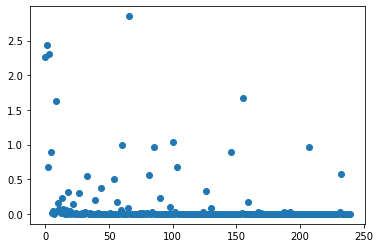

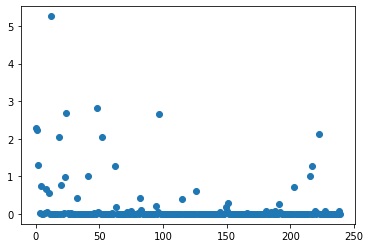

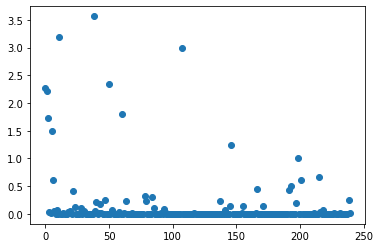

In [46]:
for client_data in losses_dict:
    x = list(range(len(losses_dict[client_data])))
    y = losses_dict[client_data]
    z = [float(a.detach()) for a in y]
    pp.plot(x, z, 'o')
    pp.show()